<a href="https://colab.research.google.com/github/JIYASINGLA/InspirationalQuotesCollection/blob/main/InfosysProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive

Testing rules on sample chunks:

Rule: positive_word_detector
Chunk 1: ['we say things will turn out but no its what we do that actually creates the future', 'do not judge me by my success judge me by how many times i fell down and got back up again', 'even in pain hope keeps us moving forward', 'your struggles today prepare you for a brighter future']
Chunk 2: ['believe that theres light at the end of the tunnel believe that you might be that light for someone else', 'believe in yourself even when life becomes hard', 'hope grows stronger each time you rise after a fall']
Chunk 3: ['the future belongs to those who believe in the beauty of their dreams', 'love is better than anger hope is better than fear optimism is better than despair so let us be', 'in dark days trust that light will come again', 'even when you feel lost hope becomes your guiding light', 'infuse your life with action dont wait for it to happen make it happen make your own future make your o

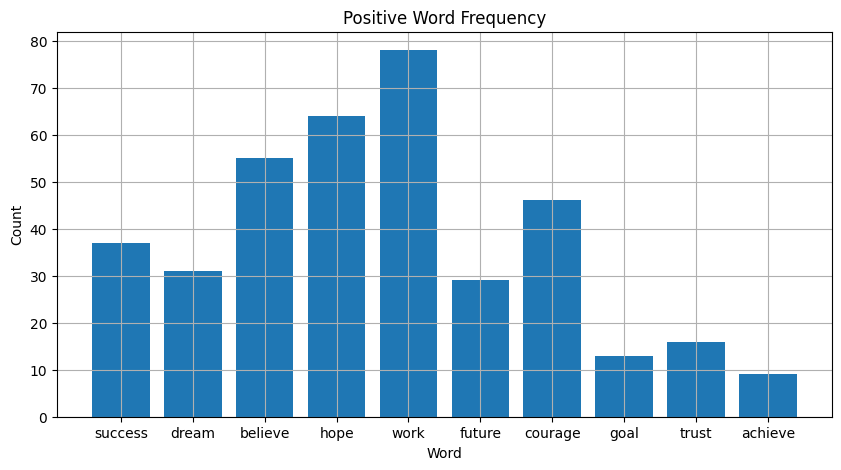

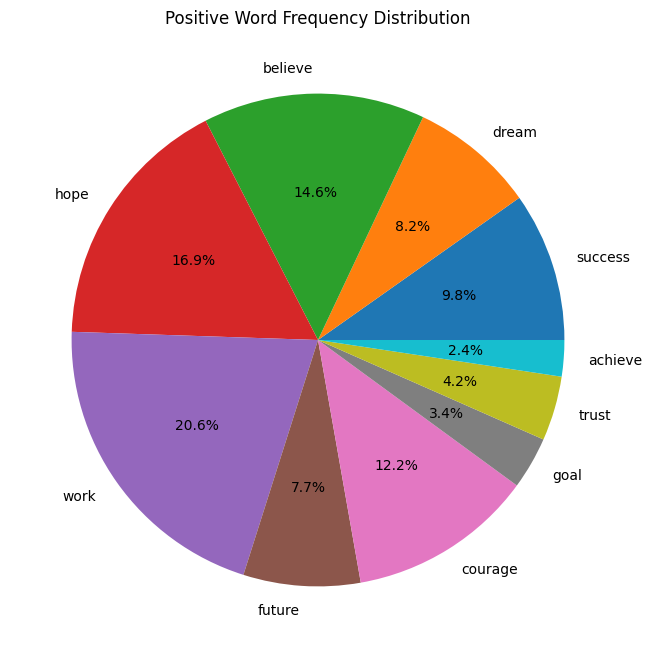

In [1]:
# STEP 1: IMPORT LIBRARIES
from google.colab import drive
drive.mount('/content/drive')

import re
import pandas as pd
import concurrent.futures
import matplotlib.pyplot as plt
import sqlite3


# STEP 2: CONFIG
FILE_PATH = '/content/drive/MyDrive/NLP_project/inspirational_quotes.txt'
CSV_OUTPUT = '/content/drive/MyDrive/NLP_project/results_inspirational_quotes.csv'
DB_OUTPUT = '/content/drive/MyDrive/NLP_project/results_inspirational_quotes.db'
RULE_PLAN_CSV = '/content/drive/MyDrive/NLP_project/rule_plan.csv'

POSITIVE_WORDS = [
    "success", "dream", "believe", "hope", "work",
    "future", "courage", "goal", "trust", "achieve"
]

CHUNK_SIZE = 20


# STEP 3: UPDATED RULES (8 RULES)
RULES = [
    {
        "rule_name": "positive_word_detector",
        "purpose": "Identify motivational and positive keywords.",
        "example_sentence": "The future belongs to those who believe in the beauty of their dreams.",
        "logic": r"\b(success|dream|believe|hope|courage|future|goal|trust|achieve)\b",
        "expected_output": "Positive keywords"
    },
    {
        "rule_name": "hope_and_struggle_detector",
        "purpose": "Detect quotes where hope appears with struggle words.",
        "example_sentence": "Even in pain, hope keeps us moving forward",
        "logic": r"\bhope\b.*\b(struggle|pain|hard)\b|\b(struggle|pain|hard)\b.*\bhope\b",
        "expected_output": "Hope + struggle quotes"
    },
    {
        "rule_name": "long_quote_detector",
        "purpose": "Identify quotes with more than 20 words.",
        "example_sentence": "Do all the good you can...",
        "logic": "(\\b\\w+\\b[\\s,.]*){20,}",
        "expected_output": "Long quotes"
    },
    {
        "rule_name": "action_word_detector",
        "purpose": "Detect action-oriented motivational words.",
        "example_sentence": "Listen with curiosity. Speak with honesty. Act with integrity.",
        "logic": r"\b(start|act|move|push|try|begin|step|rise)\b",
        "expected_output": "Action words"
    },
    {
        "rule_name": "emotion_word_detector",
        "purpose": "Detect emotional words.",
        "example_sentence": "Act of kindness.",
        "logic": r"\b(love|care|feel|joy|peace|happiness|kindness)\b",
        "expected_output": "Emotion words"
    },
    {
        "rule_name": "wisdom_word_detector",
        "purpose": "Detect wisdom or learning-based lines.",
        "example_sentence": "If you get, give. If you learn, teach.",
        "logic": r"\b(wisdom|learn|lesson|knowledge|understand)\b",
        "expected_output": "Wisdom sentences"
    },
    {
        "rule_name": "negation_detector",
        "purpose": "Detect strong motivational negations.",
        "example_sentence": "Do not judge me by my success...",
        "logic": r"\b(not|never|dont|don't|no)\b",
        "expected_output": "Negation-based motivation"
    },
    {
        "rule_name": "question_detector",
        "purpose": "Detect questions inside quotes.",
        "example_sentence": "Ask yourself: Have you been kind today?",
        "logic": r"\?",
        "expected_output": "Question-based quotes"
    }
]


# STEP 4: READ & CLEAN
def read_text_file(path):
    with open(path, 'r', encoding='utf-8', errors='replace') as f:
        return f.read()

def clean_line(line):
    line = line.lower()
    line = re.sub(r'[^\w\s\?]', '', line)  # allow "?" for question rule
    return line

def preprocess_text(raw_text):
    return [clean_line(line) for line in raw_text.split("\n")]


# STEP 5: CHUNKING
def chunk_list(data, chunk_size):
    return [data[i:i + chunk_size] for i in range(0, len(data), chunk_size)]


# STEP 6: PARALLEL PROCESS – COUNT WORDS
def process_chunk(chunk):
    counts = {word: 0 for word in POSITIVE_WORDS}

    for line in chunk:
        words = re.findall(r'\b[a-z]+\b', line)
        for w in POSITIVE_WORDS:
            counts[w] += words.count(w)

    return counts


# STEP 7: COMBINE RESULTS
def combine_results(results):
    final = {word: 0 for word in POSITIVE_WORDS}
    for result in results:
        for w, c in result.items():
            final[w] += c
    return final

# STEP 8: APPLY RULES
def apply_rule(rule, chunk):
    results = []

    for line in chunk:
        if rule["rule_name"] == "long_quote_detector":
            sentences = line.split('.')
            results.extend([s.strip() for s in sentences if len(s.split()) > 20])
        elif rule["logic"]:
            found = re.findall(rule["logic"], line)
            if found:
                results.append(line)

    return results


def test_rules_on_sample_chunks(lines):
    chunks = chunk_list(lines, CHUNK_SIZE)
    sample = chunks[:10]

    print("\nTesting rules on sample chunks:\n")

    for rule in RULES:
        print("Rule:", rule["rule_name"])
        for i, chunk in enumerate(sample):
            matches = apply_rule(rule, chunk)
            if matches:
                print(f"Chunk {i+1}:", matches)
        print()


# STEP 9: SAVE RESULTS
def save_to_csv(counts, path):
    df = pd.DataFrame(list(counts.items()), columns=['Word', 'Frequency'])
    df.to_csv(path, index=False)
    print("CSV saved:", path)
    return df

def save_to_database(df, path):
    conn = sqlite3.connect(path)
    df.to_sql('positive_word_counts', conn, if_exists='replace', index=False)
    conn.close()
    print("Database saved:", path)

def save_rule_plan_csv(rules, path):
    df = pd.DataFrame(rules)
    df.to_csv(path, index=False)
    print("Rule plan saved:", path)
    return df


# STEP 10A: BAR CHART
def plot_frequency(df):
    plt.figure(figsize=(10, 5))
    plt.bar(df['Word'], df['Frequency'])
    plt.title('Positive Word Frequency')
    plt.xlabel('Word')
    plt.ylabel('Count')
    plt.grid(True)
    plt.show()


# STEP 10B: PIE CHART (ADDED)
def plot_pie_chart(df):
    plt.figure(figsize=(8, 8))
    plt.pie(
        df['Frequency'],
        labels=df['Word'],
        autopct='%1.1f%%'
    )
    plt.title('Positive Word Frequency Distribution')
    plt.show()


# STEP 11: MAIN FUNCTION
def main():
    raw = read_text_file(FILE_PATH)
    lines = preprocess_text(raw)

    chunks = chunk_list(lines, CHUNK_SIZE)

    # Parallel processing
    with concurrent.futures.ThreadPoolExecutor() as exe:
        results = list(exe.map(process_chunk, chunks))

    final_counts = combine_results(results)

    test_rules_on_sample_chunks(lines)

    df = save_to_csv(final_counts, CSV_OUTPUT)
    save_to_database(df, DB_OUTPUT)
    save_rule_plan_csv(RULES, RULE_PLAN_CSV)

    plot_frequency(df)     # Bar chart
    plot_pie_chart(df)     # Pie chart (added)


# RUN
main()